## Calculating yearly rain and temperature seasonal variables for dry/wet year analysis
- contributes to ENSO analysis
- reads in monthly rain and max temperature data available from 1981/1983 to present
- calculates seasonal rainfall totals and mean max seasonal temperatures for each year
- calculates min, max and stdev values for each pixel across all years
- plots these maps
- regrids to the same 0.05 degree lat x 0.1 degree lon grid that the rest of the analysis was done on. 
- sub-basin averages, plotted as a time-series, with +/- standard deviation marked
- outputs to be used within beta regression model
- variables - DJF, MAM, JJA, SON, Dry_diff, Total wet season (TWS), DJF_Tmax, SON_Tmax
- plots density plots for yearly distribution of each variable.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
#import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
import geopandas
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import math


In [2]:
WRKDIR = '/home/s0677837/Datastore/PHD/'
CHIRPS = WRKDIR + 'CHIRPS/Monthly/'
CHIRTS = WRKDIR + 'CHIRTS/'
PKL = WRKDIR + 'PKL/'

# loading the ~50m vegetation map - an array of 13 sub-basins
# following the method defined for the 250m map in the code: CHIRPS_AET_calculation_full_CC.ipynb

# vegetation rasters
V_rasters = WRKDIR + '/Veg_maps/final_basins/50m/'

In [3]:
# full map extent (from full vegetation map extent)
lat_min = -5.06319436
lat_max = 3.29741657
lon_min = 14.99769448
lon_max = 25.78052774

In [4]:
# cartopy river and lake features to be added to the maps
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='black')

lakes = cartopy.feature.NaturalEarthFeature(
    category='physical', name='lakes',
    scale='10m', facecolor='none', edgecolor='aqua')


In [5]:
# reading in the shapefile footprint
import shapefile as shp
footprint = shp.Reader(WRKDIR + '/Veg_maps/CC_footprint.shp')

In [6]:
def plot_map(ds,variable,cmap_name,label,t,b,l,r,vmin,vmax):
    # Function to plot map data with river and lake features overplotted.
    # inputs: data array, variable, colour map, legend lable, plot ticks for top, bottom, left and right,cbar min, cbar max
    # e.g. plot_map(clim_chirps_annual,'Annual','viridis_r','Annual rainfall (mm)',True,True,True,True,0,2100)
    sns.set(font_scale=1.7, style="white")

    fig, ax = plt.subplots(
        nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()},
                             figsize=(11.1, 9.4))
    ax.add_feature(rivers, linewidth=1)
    ax.add_feature(lakes, linewidth=1)
    lat_min = -5.03769436
    lat_max = 3.26980564
    ax.set_extent([15,23,-4, lat_max])
    cmap = plt.cm.get_cmap(cmap_name)
    im = ds[variable].plot(cmap=cmap,vmin=vmin,vmax=vmax,cbar_kwargs=dict(orientation='horizontal', pad=0.07,shrink=0.71,label=label))
    # adding 2nd axes labels
    ax.tick_params(labeltop=True, labelright=True)
    
    for shape in footprint.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color='white')

    labelsx=['0','16$^\circ$E','18$^\circ$E','20$^\circ$E','22$^\circ$E']
    ax.set_xticklabels(labelsx)
    ax.set_xlim(15,23)
    # turning off x and y label titles
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    x_label.set_visible(False)

    y_axis = ax.axes.get_yaxis()
    y_label = y_axis.get_label()
    y_label.set_visible(False)


    labelsy=['0','4$^\circ$S','3$^\circ$S','2$^\circ$S','1$^\circ$S','0$^\circ$','1$^\circ$N','2$^\circ$N','3$^\circ$N']
    ax.set_yticklabels(labelsy)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = t
    gl.xlabels_bottom = b
    gl.ylabels_left = l
    gl.ylabels_right = r
    gl.xlines = True

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([16, 17, 18, 19, 20, 21, 22, 23])
    gl.ylocator = mticker.FixedLocator([-4,-3,-2,-1,0,1,2,3])
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    gl.xlabel_style = {'size': 15, 'color': 'black'}


    plt.show()    

In [13]:
def add_lat_lon_cat(df_orig,df_grid_lats,df_grid_lons,lat_mid,lon_mid):
    # a function to add the lat and long category values that each of the finer resolution lat/longs lie within
    # example usage: add_lat_lon_cat(R_min_df,df_grid_lats,df_grid_lons,lat_mid,lon_mid)
    dfs_lats = []
    dfs_lons = []

    for i in range(len(df_grid_lats)):
        min = float(df_grid_lats['lats'][i] - lat_mid)
        max = float(df_grid_lats['lats'][i] + lat_mid)
        #print (i,min,max)
        df = df_orig.loc[(df_orig['lat']>=min) & (df_orig['lat']<max)].copy()
        df['lat_cat']= df_grid_lats['lat_cat'][i]
        dfs_lats.append(df)

    for i in range(len(df_grid_lons)):
        min = float(df_grid_lons['lons'][i] - lon_mid)
        max = float(df_grid_lons['lons'][i] + lon_mid)
        #print (i,min,max)
        df = df_orig.loc[(df_orig['lon']>=min) & (df_orig['lon']<max)].copy()
        df['lon_cat']= df_grid_lons['lon_cat'][i]
        dfs_lons.append(df)
        #veg2.loc[(veg2['lon']>=min) & (veg2['lon']<=max)]['lon_cat'] = df_grid_lons['lon_cat'][i] 


    #print (len(R_min_1km),len(dfs_lats),len(dfs_lons)) 

    # concatenating the lat and lon category dataframes across all grid lat/lons
    dfs_lats = pd.concat(dfs_lats)
    dfs_lons = pd.concat(dfs_lons)

    #print (dfs_lats)

    # matching on lat and long columns to merge 
    cols_to_use = dfs_lons.columns.difference(dfs_lats.columns)

    # merging the lat and lon categories
    df_new = pd.merge(dfs_lats, dfs_lons, on=['lat','lon'], how='outer', suffixes=('', '_y'))

    # dropping any rows where lat or lon_cat is NaN
    df_new = df_new.dropna()

    cols = dfs_lats.columns.to_list()
    cols = cols + ['lon_cat']

    # dropping unnescessary columns: index and index_y and reordering
    df_new = df_new[cols]
    
    return df_new

In [7]:
%%time
# reading and concatenating all of the monthly rainfall data into a pandas dataframe
R_all = []

for mo in range(1,13):
    mo = str(mo).zfill(2)
    R_yrs = []

    for yr in range(1981,2010):
        # opening each image
        ds = xr.open_rasterio(CHIRPS + 'chirps-v2.0.'+ str(yr) + '.' + mo +'.tif')

        # renaming x and y dimensions to the same as the ALOS imagery
        ds = ds.rename({'x': 'longitude','y': 'latitude', })

        # cutting out to ALOS image size
        im = ds.where((lon_min < ds.longitude) & (ds.longitude < lon_max) & (lat_min < ds.latitude) & (ds.latitude < lat_max), drop=True)            

        # setting no values (currently -9999.0) to nan
        im = im.where(im != -9999., drop=True)   

        # converting from DataArray to Dataset format
        im = im.to_dataset(dim='band')

        # creating values and key pairs to rename the variables within the final concatenated array 
        # they are currently all labelled 1
        values = []
        values.append(str(yr))
        keys = im.keys()
        dictionary = dict(zip(keys, values))

        # changing the variable name to the month value
        im = im.rename_vars(dictionary)
        df = im.to_dataframe().reset_index()
        df['year'] = str(yr)
        df.columns = ['latitude','longitude','value','year']
        R_yrs.append(df)

    # appending each yearly image to the array of all images
    R_yrs = pd.concat(R_yrs)
    R_yrs['month'] = mo
    R_all.append(R_yrs)

R_all = pd.concat(R_all)
R_all

latitude  longitude       value  year month
0      3.274999  15.025001   26.943787  1981    01
1      3.274999  15.075001   27.641106  1981    01
2      3.274999  15.125001   29.059814  1981    01
3      3.274999  15.175001   30.540970  1981    01
4      3.274999  15.225001   32.223022  1981    01
...         ...        ...         ...   ...   ...
36067 -5.025001  25.575001  165.068298  2009    12
36068 -5.025001  25.625001  164.262360  2009    12
36069 -5.025001  25.675001  165.221863  2009    12
36070 -5.025001  25.725001  162.147202  2009    12
36071 -5.025001  25.775001  160.358978  2009    12

[12553056 rows x 5 columns]

In [8]:
# calculating seasonal totals
R_DJF = R_all[R_all['month'].isin(['12','01','02'])].groupby(['latitude','longitude','year']).sum().reset_index()
R_MAM = R_all[R_all['month'].isin(['03','04','05'])].groupby(['latitude','longitude','year']).sum().reset_index()
R_JJA = R_all[R_all['month'].isin(['06','07','08'])].groupby(['latitude','longitude','year']).sum().reset_index()
R_SON = R_all[R_all['month'].isin(['09','10','11'])].groupby(['latitude','longitude','year']).sum().reset_index()

# rename new column to its seasonal name
R_DJF.rename(columns={'value':'DJF'}, inplace=True)
R_MAM.rename(columns={'value':'MAM'}, inplace=True)
R_JJA.rename(columns={'value':'JJA'}, inplace=True)
R_SON.rename(columns={'value':'SON'}, inplace=True)

In [9]:
# merge the 4 rain season dfs
df1 = pd.merge(R_DJF,R_MAM)
df2 = pd.merge(R_JJA,R_SON)
R_df = pd.merge(df1,df2)

# add dry diff and total wet season columns
R_df['Dry_diff'] = R_df['JJA'] - R_df['DJF']
R_df['TWS'] = R_df['MAM']+R_df['SON']
R_df['Annual'] = R_df['DJF'] + R_df['MAM'] + R_df['JJA'] + R_df['SON']
R_df['TDS'] = R_df['DJF'] + R_df['JJA']

R_df

latitude  longitude  year         DJF         MAM         JJA  \
0       -5.025001  15.025001  1981  526.112549  445.143402    6.220600   
1       -5.025001  15.025001  1982  582.645569  400.805481    3.338253   
2       -5.025001  15.025001  1983  530.013062  508.265686    3.161453   
3       -5.025001  15.025001  1984  394.195251  434.536560    5.092983   
4       -5.025001  15.025001  1985  453.728302  584.619446    4.772558   
...           ...        ...   ...         ...         ...         ...   
1046083  3.274999  25.775001  2005  121.838440  469.870178  515.758057   
1046084  3.274999  25.775001  2006  124.033234  508.788330  471.438782   
1046085  3.274999  25.775001  2007   83.286591  468.852539  475.602783   
1046086  3.274999  25.775001  2008  146.867172  532.639526  551.726440   
1046087  3.274999  25.775001  2009  234.873993  513.413818  467.889801   

                SON    Dry_diff          TWS       Annual         TDS  
0        456.929840 -519.891968   902.073242  1434.406372  532.333130  
1        320.470398 -579.307312   721.275879  1307.259766  585.983826  
2        401.391388 -526.851624   909.657104  1442.831665  533.174500  
3        471.252045 -389.102264   905.788574  1305.076782  399.288239  
4        361.085754 -448.955750   945.705200  1404.206055  458.500854  
...             ...         ...          ...          ...         ...  
1046083  455.774231  393.919617   925.644409  1563.240967  637.596497  
1046084  589.069946  347.405548  1097.858276  1693.330200  595.472046  
1046085  449.523712  392.316193   918.376221  1477.265625  558.889404  
1046086  495.822327  404.859253  1028.461914  1727.055420  698.593628  
1046087  486.872559  233.015808  1000.286377  1703.050171  702.763794  

[1046088 rows x 11 columns]

In [10]:
# Calculate the min, max and standard deviation of each variable across all years for each lat, lon pair
# extend to 2021?
# currently 1981 to end of 2009
R_df_min = R_df.groupby(['latitude','longitude']).min().reset_index()
R_df_max = R_df.groupby(['latitude','longitude']).max().reset_index()
R_df_stdev = R_df.groupby(['latitude','longitude']).std().reset_index()
R_df_stdev

latitude  longitude        DJF        MAM        JJA         SON  \
0     -5.025001  15.025001  77.309594  84.881280   2.868012   97.298203   
1     -5.025001  15.075001  77.621514  85.846261   3.232825   96.883149   
2     -5.025001  15.125001  75.615289  88.982858   3.400172   98.751738   
3     -5.025001  15.175001  77.090999  88.647561   3.108835  100.215903   
4     -5.025001  15.225001  76.214678  89.583832   3.099965  101.808684   
...         ...        ...        ...        ...        ...         ...   
36067  3.274999  25.575001  40.421320  70.222798  54.077838   75.461172   
36068  3.274999  25.625001  40.396883  70.605905  53.988055   72.912763   
36069  3.274999  25.675001  39.367182  71.951249  44.922189   65.419865   
36070  3.274999  25.725001  39.251149  71.570798  45.146262   66.095770   
36071  3.274999  25.775001  41.015655  70.747856  48.832213   68.453665   

        Dry_diff         TWS      Annual        TDS  
0      77.287623  123.325373  138.646754  77.437852  
1      77.625297  121.983926  138.137565  77.752262  
2      75.317119  127.057703  136.826867  76.064431  
3      76.880562  131.366434  144.068879  77.425792  
4      75.987703  133.110152  146.033413  76.566592  
...          ...         ...         ...        ...  
36067  70.830376   95.833267  119.735327  64.028499  
36068  71.442387   97.175795  115.219987  63.160294  
36069  64.067630   95.172363  116.005769  55.053562  
36070  63.630612   96.319747  118.603770  55.756798  
36071  68.268812   95.331975  119.609640  58.933065  

[36072 rows x 10 columns]

In [11]:
# converting to xarray for plotting
R_ds_min = R_df_min.set_index(['latitude','longitude']).to_xarray()
R_ds_max = R_df_max.set_index(['latitude','longitude']).to_xarray()
R_ds_std = R_df_stdev.set_index(['latitude','longitude']).to_xarray()
R_ds_min

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216)
Coordinates:
  * latitude   (latitude) float64 -5.025 -4.975 -4.925 ... 3.175 3.225 3.275
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
Data variables:
    year       (latitude, longitude) object '1981' '1981' ... '1981' '1981'
    DJF        (latitude, longitude) float32 377.0 377.7 379.0 ... 82.97 83.29
    MAM        (latitude, longitude) float32 328.4 325.5 324.6 ... 324.6 330.9
    JJA        (latitude, longitude) float32 2.852 4.014 4.005 ... 347.4 366.4
    SON        (latitude, longitude) float32 255.2 248.9 247.0 ... 425.7 424.8
    Dry_diff   (latitude, longitude) float32 -615.6 -632.0 ... 164.5 179.6
    TWS        (latitude, longitude) float32 721.3 719.3 732.6 ... 819.2 832.6
    Annual     (latitude, longitude) float32 1.26e+03 1.251e+03 ... 1.453e+03
    TDS        (latitude, longitude) float32 379.9 381.9 383.2 ... 530.3 505.8

In [22]:
R_ds_std['DJF'].min()

<xarray.DataArray 'DJF' ()>
array(20.13599341)

<ipython-input-18-56dfad74fe30>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx)
<ipython-input-18-56dfad74fe30>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy)


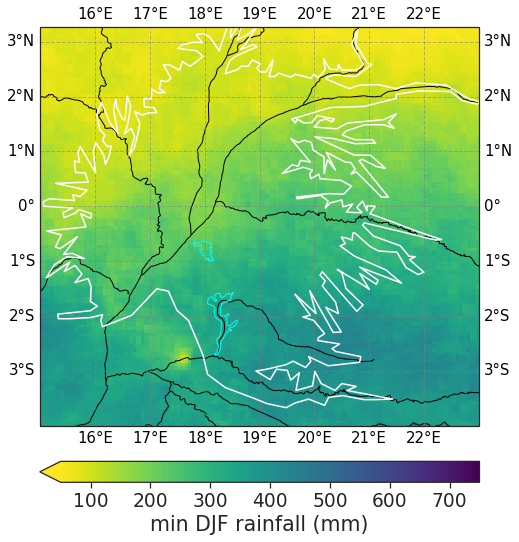

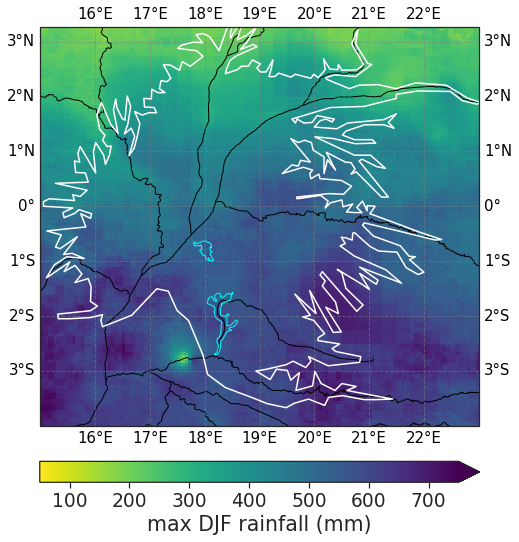

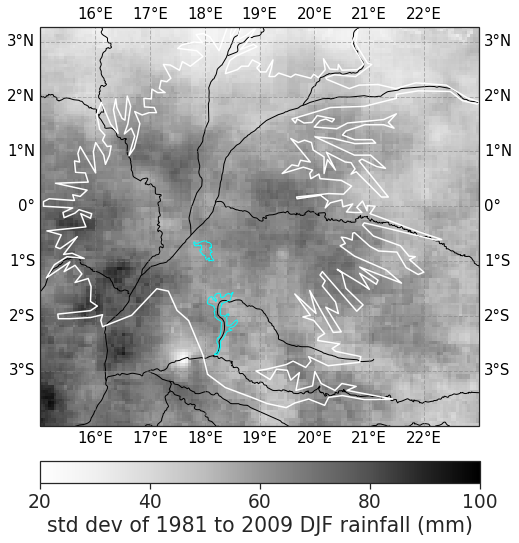

In [29]:
# plotting the min, max and stdev data for each variable
#f, ((ax1, ax2, ax3)) = plt.subplots(3,1, figsize=(8, 17))

plot_map(R_ds_min,'DJF','viridis_r','min DJF rainfall (mm)',True,True,True,True,50,750)
plot_map(R_ds_max,'DJF','viridis_r','max DJF rainfall (mm)',True,True,True,True,50,750)
plot_map(R_ds_std, 'DJF','Greys','std dev of 1981 to 2009 DJF rainfall (mm)',True,True,True,True,20,100)

In [24]:
R_ds_std['Dry_diff'].min()

<xarray.DataArray 'Dry_diff' ()>
array(36.46514436)

<ipython-input-18-56dfad74fe30>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx)
<ipython-input-18-56dfad74fe30>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy)


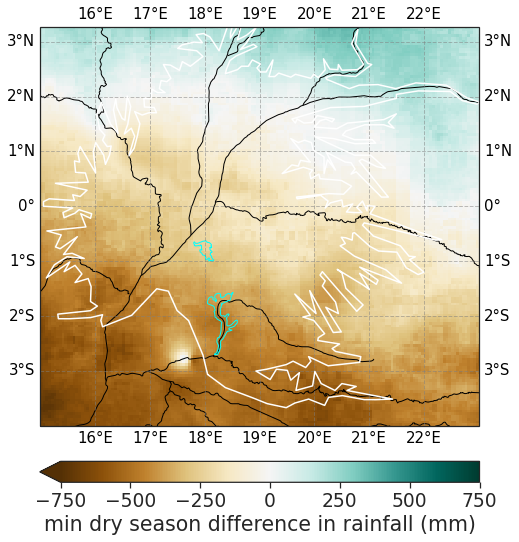

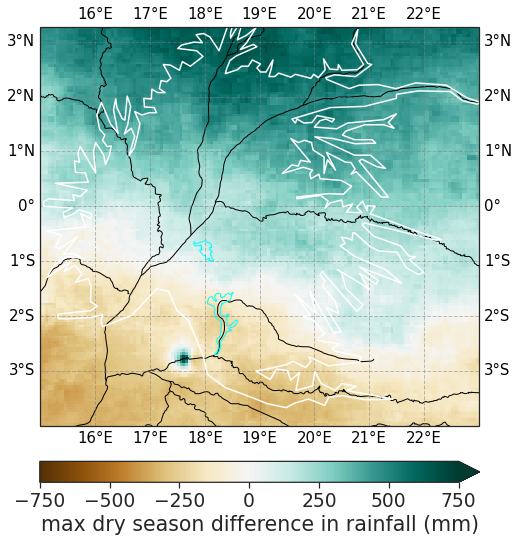

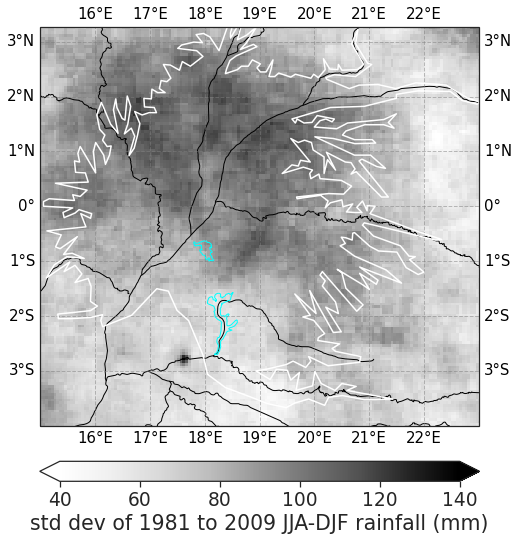

In [28]:
plot_map(R_ds_min,'Dry_diff','BrBG','min dry season difference in rainfall (mm)',True,True,True,True,-750,750)
plot_map(R_ds_max,'Dry_diff','BrBG','max dry season difference in rainfall (mm)',True,True,True,True,-750,750)
plot_map(R_ds_std, 'Dry_diff','Greys','std dev of 1981 to 2009 JJA-DJF rainfall (mm)',True,True,True,True,40,140)

In [26]:
R_ds_std['Annual'].max()

<xarray.DataArray 'Annual' ()>
array(199.86849767)

<ipython-input-18-56dfad74fe30>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx)
<ipython-input-18-56dfad74fe30>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy)


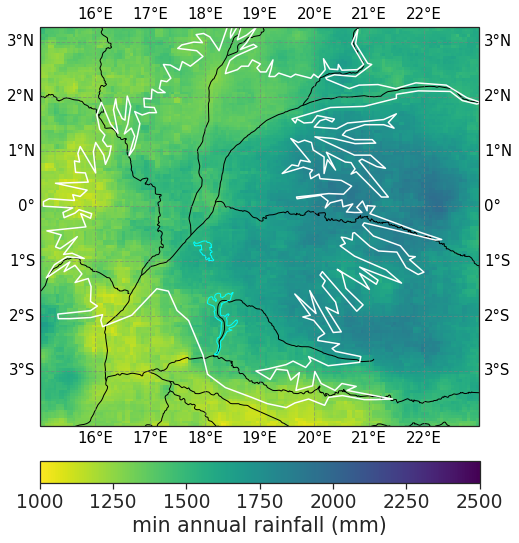

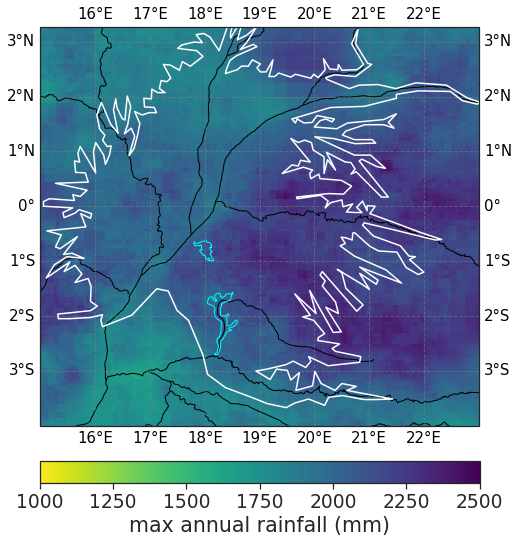

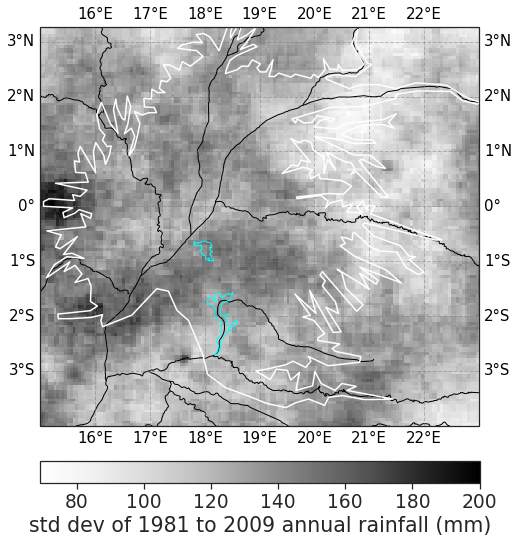

In [30]:
plot_map(R_ds_min,'Annual','viridis_r','min annual rainfall (mm)',True,True,True,True,1000,2500)
plot_map(R_ds_max,'Annual','viridis_r','max annual rainfall (mm)',True,True,True,True,1000,2500)
plot_map(R_ds_std, 'Annual','Greys','std dev of 1981 to 2009 annual rainfall (mm)',True,True,True,True,69,200)

In [232]:
R_ds_std['TDS'].min()

<xarray.DataArray 'TDS' ()>
array(31.55618816)

<ipython-input-18-56dfad74fe30>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx)
<ipython-input-18-56dfad74fe30>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy)


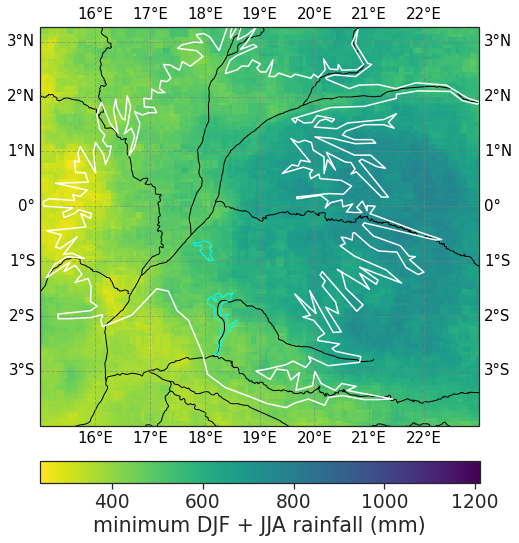

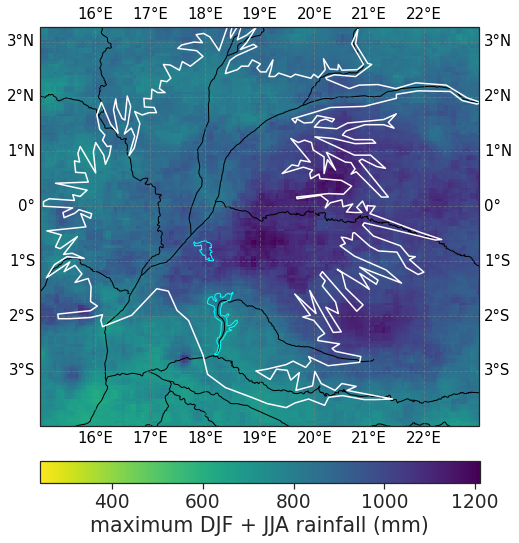

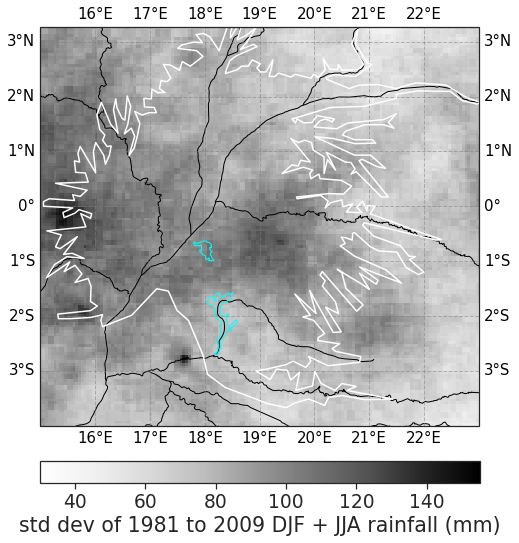

In [31]:
plot_map(R_ds_min,'TDS','viridis_r','minimum DJF + JJA rainfall (mm)',True,True,True,True,240,1210)
plot_map(R_ds_max,'TDS','viridis_r','maximum DJF + JJA rainfall (mm)',True,True,True,True,240,1210)
plot_map(R_ds_std, 'TDS','Greys','std dev of 1981 to 2009 DJF + JJA rainfall (mm)',True,True,True,True,30,155)

In [12]:
# temperature yearly data
T_all = []

for mo in range(1,13):
    mo = str(mo).zfill(2)
    T_yrs = []

    for yr in range(1983,2010):
        # opening each image
        ds = xr.open_rasterio(CHIRTS + 'CHIRTSmax.'+ str(yr) + '.' + mo +'.tif')

        # renaming x and y dimensions to the same as the ALOS imagery
        ds = ds.rename({'x': 'longitude','y': 'latitude', })

        # cutting out to ALOS image size
        im = ds.where((lon_min < ds.longitude) & (ds.longitude < lon_max) & (lat_min < ds.latitude) & (ds.latitude < lat_max), drop=True)            

        # setting no values (currently -9999.0) to nan
        im = im.where(im != -9999., drop=True)   

        # converting from DataArray to Dataset format
        im = im.to_dataset(dim='band')

        # creating values and key pairs to rename the variables within the final concatenated array 
        # they are currently all labelled 1
        values = []
        values.append(str(yr))
        keys = im.keys()
        dictionary = dict(zip(keys, values))

        # changing the variable name to the month value
        im = im.rename_vars(dictionary)
        df = im.to_dataframe().reset_index()
        df['year'] = str(yr)
        df.columns = ['latitude','longitude','value','year']
        T_yrs.append(df)

    # appending each yearly image to the array of all images
    T_yrs = pd.concat(T_yrs)
    T_yrs['month'] = mo
    T_all.append(T_yrs)

T_all = pd.concat(T_all)
T_all

latitude  longitude      value  year month
0      3.274999  15.025003  30.542948  1983    01
1      3.274999  15.075003  30.458120  1983    01
2      3.274999  15.125003  30.411264  1983    01
3      3.274999  15.175003  30.420504  1983    01
4      3.274999  15.225003  30.332979  1983    01
...         ...        ...        ...   ...   ...
36067 -5.025001  25.575003  30.005636  2009    12
36068 -5.025001  25.625003  29.935158  2009    12
36069 -5.025001  25.675003  29.883863  2009    12
36070 -5.025001  25.725003  29.871735  2009    12
36071 -5.025001  25.775003  29.864874  2009    12

[11687328 rows x 5 columns]

In [13]:
# calculating seasonal average Tmax
T_DJF = T_all[T_all['month'].isin(['12','01','02'])].groupby(['latitude','longitude','year']).mean().reset_index()
T_MAM = T_all[T_all['month'].isin(['03','04','05'])].groupby(['latitude','longitude','year']).mean().reset_index()
T_JJA = T_all[T_all['month'].isin(['06','07','08'])].groupby(['latitude','longitude','year']).mean().reset_index()
T_SON = T_all[T_all['month'].isin(['09','10','11'])].groupby(['latitude','longitude','year']).mean().reset_index()

# rename new column to its seasonal name
T_DJF.rename(columns={'value':'DJF_Tmax'}, inplace=True)
T_MAM.rename(columns={'value':'MAM_Tmax'}, inplace=True)
T_JJA.rename(columns={'value':'JJA_Tmax'}, inplace=True)
T_SON.rename(columns={'value':'SON_Tmax'}, inplace=True)

In [14]:
# merge the 4 temperature season dfs
df1 = pd.merge(T_DJF,T_MAM)
df2 = pd.merge(T_JJA,T_SON)
T_df = pd.merge(df1,df2)

T_df

latitude  longitude  year   DJF_Tmax   MAM_Tmax   JJA_Tmax   SON_Tmax
0      -5.025001  15.025003  1983  29.236599  29.882929  26.469595  28.329542
1      -5.025001  15.025003  1984  29.031658  29.748058  27.762224  28.592215
2      -5.025001  15.025003  1985  28.877022  29.481077  27.092781  28.320419
3      -5.025001  15.025003  1986  29.064104  30.036070  27.398420  28.458189
4      -5.025001  15.025003  1987  29.120499  30.020405  27.769133  28.527504
...          ...        ...   ...        ...        ...        ...        ...
973939  3.274999  25.775003  2005  32.557793  31.172785  29.067196  30.583668
973940  3.274999  25.775003  2006  31.984493  30.363260  29.319197  29.786253
973941  3.274999  25.775003  2007  32.161591  31.532288  28.651825  30.036552
973942  3.274999  25.775003  2008  31.338764  30.350485  28.752859  30.374338
973943  3.274999  25.775003  2009  31.135908  30.671904  29.845705  30.464273

[973944 rows x 7 columns]

In [15]:
# Calculate the min, max and standard deviation of each variable across all years for each lat, lon pair
# extend to 2021?
# currently 1983 to end of 2009
T_df_min = T_df.groupby(['latitude','longitude']).min().reset_index()
T_df_max = T_df.groupby(['latitude','longitude']).max().reset_index()
T_df_stdev = T_df.groupby(['latitude','longitude']).std().reset_index()
T_df_stdev

latitude  longitude  DJF_Tmax  MAM_Tmax  JJA_Tmax  SON_Tmax
0     -5.025001  15.025003  0.246620  0.301980  0.443553  0.250063
1     -5.025001  15.075003  0.246207  0.301005  0.439986  0.249688
2     -5.025001  15.125003  0.244754  0.301542  0.438228  0.250006
3     -5.025001  15.175003  0.242423  0.303065  0.438397  0.251030
4     -5.025001  15.225003  0.239834  0.303880  0.438806  0.252449
...         ...        ...       ...       ...       ...       ...
36067  3.274999  25.575003  0.630945  0.551106  0.424858  0.527891
36068  3.274999  25.625003  0.636705  0.558342  0.428403  0.531902
36069  3.274999  25.675003  0.637920  0.562406  0.429097  0.535481
36070  3.274999  25.725003  0.635605  0.565560  0.429698  0.537738
36071  3.274999  25.775003  0.631959  0.566014  0.431183  0.537592

[36072 rows x 6 columns]

In [16]:
# converting to xarray for plotting
T_ds_min = T_df_min.set_index(['latitude','longitude']).to_xarray()
T_ds_max = T_df_max.set_index(['latitude','longitude']).to_xarray()
T_ds_std = T_df_stdev.set_index(['latitude','longitude']).to_xarray()
T_ds_min

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216)
Coordinates:
  * latitude   (latitude) float64 -5.025 -4.975 -4.925 ... 3.175 3.225 3.275
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
Data variables:
    year       (latitude, longitude) object '1983' '1983' ... '1983' '1983'
    DJF_Tmax   (latitude, longitude) float32 28.43 29.07 29.0 ... 29.84 29.82
    MAM_Tmax   (latitude, longitude) float32 29.17 29.81 29.75 ... 29.71 29.68
    JJA_Tmax   (latitude, longitude) float32 26.34 26.74 26.75 ... 28.1 28.06
    SON_Tmax   (latitude, longitude) float32 28.13 28.76 28.7 ... 29.03 28.99

<ipython-input-18-56dfad74fe30>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labelsx)
<ipython-input-18-56dfad74fe30>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labelsy)
/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribut

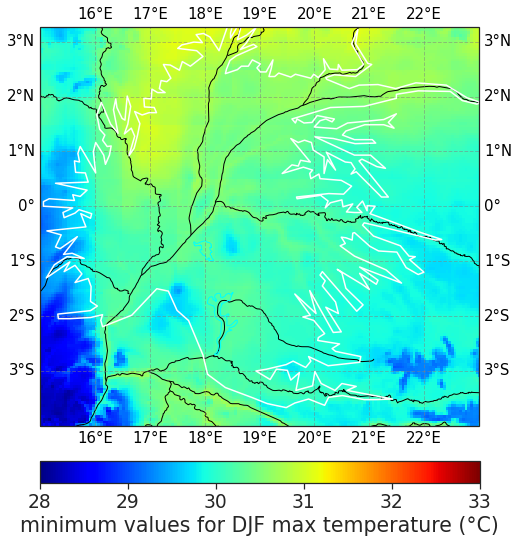

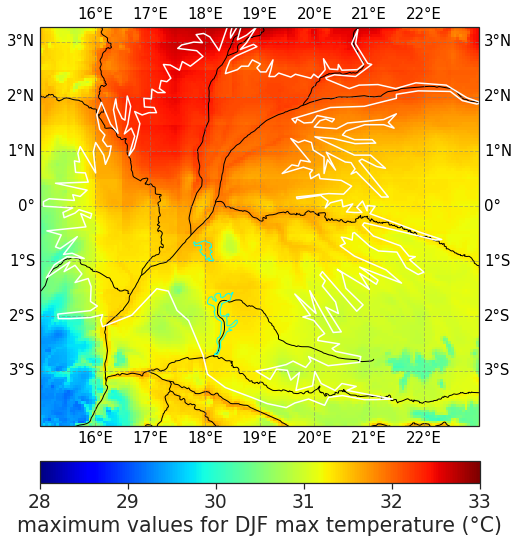

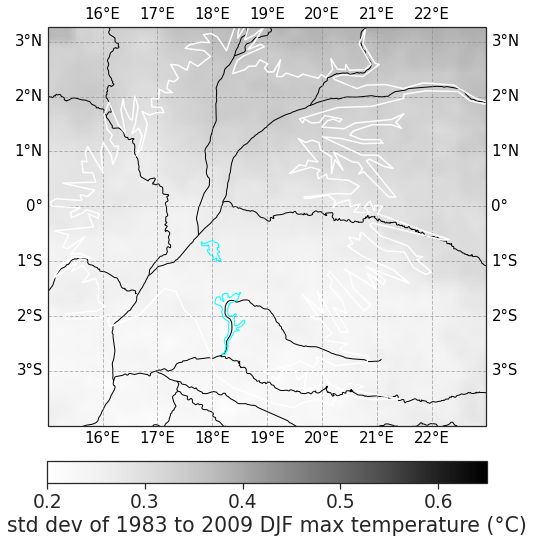

In [37]:
plot_map(T_ds_min,'DJF_Tmax','jet','min values for DJF max temperature (°C)',True,True,True,True,28,33)
plot_map(T_ds_max,'DJF_Tmax','jet','max values for DJF max temperature (°C)',True,True,True,True,28,33)
plot_map(T_ds_std, 'DJF_Tmax','Greys','std dev of 1983 to 2009 DJF max temperature (°C)',True,True,True,True,0.2,0.65)

In [22]:
T_ds_std['DJF_Tmax'].min()

<xarray.DataArray 'DJF_Tmax' ()>
array(0.20517249)

In [17]:
# converting the full by year data to xarrays
R_ds_years = R_df.set_index(['latitude','longitude','year']).to_xarray()
T_ds_years = T_df.set_index(['latitude','longitude','year']).to_xarray()
R_ds_years

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 216, year: 29)
Coordinates:
  * latitude   (latitude) float64 -5.025 -4.975 -4.925 ... 3.175 3.225 3.275
  * longitude  (longitude) float64 15.03 15.08 15.13 15.18 ... 25.68 25.73 25.78
  * year       (year) object '1981' '1982' '1983' ... '2007' '2008' '2009'
Data variables:
    DJF        (latitude, longitude, year) float32 526.1 582.6 ... 146.9 234.9
    MAM        (latitude, longitude, year) float32 445.1 400.8 ... 532.6 513.4
    JJA        (latitude, longitude, year) float32 6.221 3.338 ... 551.7 467.9
    SON        (latitude, longitude, year) float32 456.9 320.5 ... 495.8 486.9
    Dry_diff   (latitude, longitude, year) float32 -519.9 -579.3 ... 404.9 233.0
    TWS        (latitude, longitude, year) float32 902.1 721.3 ... 1e+03
    Annual     (latitude, longitude, year) float32 1.434e+03 ... 1.703e+03
    TDS        (latitude, longitude, year) float32 532.3 586.0 ... 698.6 702.8

## Regridding to 0.1 lat x 0.05 degree lon grid

In [18]:
# QUICK START from here for loading the vegn map (full code in rclim_grid_5km.ipynb)
#veg = pkl.load(open(PKL + "regridded_veg_13basins_full_resn.pkl", "rb"))
#veg
# QUICK START from here for loading the vegn 50m dataframe with lat and long categories defined
veg = pkl.load(open(PKL + "veg3_50m.pkl", "rb"))
veg

lat        lon  lat_cat  lon_cat  basin  type
0         -4.963778  18.022444      2.0       31    8.0   2.0
1         -4.963778  18.022889      2.0       31    8.0   2.0
2         -4.963778  18.023333      2.0       31    8.0   3.0
3         -4.963778  18.023778      2.0       31    8.0   3.0
4         -4.963778  18.024222      2.0       31    8.0   3.0
...             ...        ...      ...      ...    ...   ...
336168565  3.247333  23.970444    168.0       90    2.0   3.0
336168566  3.247333  23.970889    168.0       90    2.0   3.0
336168567  3.247333  23.971333    168.0       90    2.0   3.0
336168568  3.247333  23.971778    168.0       90    2.0   3.0
336168569  3.247333  23.972222    168.0       90    2.0   3.0

[336168570 rows x 6 columns]

In [19]:
# grouping by basin also, means that some lat/lon cats could belong to more than one basin 
# rounding to nearest basin number, so that if a lat lon cat spans two basins, it is categorised as being in the 
# basin where most of its pixels are.
basin_df = veg.groupby(['lat_cat','lon_cat']).mean().reset_index()
basin_df.drop(['lat','lon','type'],axis=1,inplace=True)
basin_df['basin'] = basin_df['basin'].round()

In [20]:
# saving basin_df to pkl 
with open(PKL + 'basin_df.pkl', 'wb') as f:
    pkl.dump(basin_df, f)

In [21]:
df = basin_df.copy()
print (len(df['lat_cat'].unique()), len(df['lon_cat'].unique()),len(df['lat_cat'].unique())*len(df['lon_cat'].unique()))

167 100 16700


In [22]:
# reading in CHIRPS seasonal rainfall climatology 1km
# created in the code: calculate_seasonal_rainfall_climatology.ipynb
# 837 lat x 1079 lon
chirps_clim = pkl.load(open(PKL + 'clim_chirps_seasons_full_map_1km.pkl', 'rb'))
chirps_clim

<xarray.Dataset>
Dimensions:  (lat: 837, lon: 1079)
Coordinates:
  * lon      (lon) float64 15.0 15.01 15.02 15.03 ... 25.75 25.76 25.77 25.78
  * lat      (lat) float64 -5.063 -5.053 -5.043 -5.033 ... 3.277 3.287 3.297
Data variables:
    DJF      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    MAM      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    JJA      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SON      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [23]:
land_types = ["water","savannah","terra firme", "palm swamp", "hardwood swamp"]
lats=len(chirps_clim['lat'])
lons=len(chirps_clim['lon'])

# extent in km
print (lats,lons)

# defining the lat/long extents of the grid
la = chirps_clim['lat']
lo = chirps_clim['lon']
lon_min = lo[0]
lon_max = lo[-1]
lat_min = la[0]
lat_max = la[-1]
print (la[0], la[-1], lo[0], lo[-1])

837 1079
<xarray.DataArray 'lat' ()>
array(-5.06319436)
Coordinates:
    lat      float64 -5.063 <xarray.DataArray 'lat' ()>
array(3.29680564)
Coordinates:
    lat      float64 3.297 <xarray.DataArray 'lon' ()>
array(14.99769448)
Coordinates:
    lon      float64 15.0 <xarray.DataArray 'lon' ()>
array(25.77769448)
Coordinates:
    lon      float64 25.78


In [24]:
# regridding all parameters to the same grid as chirps_clim

shift = 0.0  # when not interpolating to the same grid as another map, no shift is required.

# shift2 required to ensure grid is the same as for the water products
shift2 = 0.01
ds_out_1km = xr.Dataset({'lat': (['lat'], np.arange(lat_min + shift, lat_max + shift2, 0.01)),
                     'lon': (['lon'], np.arange(lon_min + shift, lon_max + shift2, 0.01)),
                    }
                   )
ds_out_1km

<xarray.Dataset>
Dimensions:  (lat: 837, lon: 1079)
Coordinates:
  * lat      (lat) float64 -5.063 -5.053 -5.043 -5.033 ... 3.277 3.287 3.297
  * lon      (lon) float64 15.0 15.01 15.02 15.03 ... 25.75 25.76 25.77 25.78
Data variables:
    *empty*

In [25]:
# regridding rainfall and temperature data to 1km initially 
regridder_1km = xe.Regridder(R_ds_min['DJF'], ds_out_1km, 'bilinear')
                                      
# RAIN data min, max, stdev
R_min_1km = regridder_1km(R_ds_min[['DJF','MAM','JJA','SON','Dry_diff','TWS','Annual','TDS']])
R_max_1km = regridder_1km(R_ds_max[['DJF','MAM','JJA','SON','Dry_diff','TWS','Annual','TDS']])
R_std_1km = regridder_1km(R_ds_std[['DJF','MAM','JJA','SON','Dry_diff','TWS','Annual','TDS']])

R_min_df = R_min_1km.to_dataframe().reset_index()
R_max_df = R_max_1km.to_dataframe().reset_index()
R_std_df = R_std_1km.to_dataframe().reset_index()

# temp data min, max, stdev
T_min_1km = regridder_1km(T_ds_min[['DJF_Tmax','MAM_Tmax','JJA_Tmax','SON_Tmax']])
T_max_1km = regridder_1km(T_ds_max[['DJF_Tmax','MAM_Tmax','JJA_Tmax','SON_Tmax']])
T_std_1km = regridder_1km(T_ds_std[['DJF_Tmax','MAM_Tmax','JJA_Tmax','SON_Tmax']])

T_min_df = T_min_1km.to_dataframe().reset_index()
T_max_df = T_max_1km.to_dataframe().reset_index()
T_std_df = T_std_1km.to_dataframe().reset_index()
                                      


/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/xesmf/frontend.py:487: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [26]:
# rain data by year
R_all_1km =  regridder_1km(R_ds_years[['DJF','MAM','JJA','SON','Dry_diff','TWS','Annual','TDS']])      
R_all_df = R_all_1km.to_dataframe().reset_index()

T_all_1km = regridder_1km(T_ds_years[['DJF_Tmax','MAM_Tmax','JJA_Tmax','SON_Tmax']])
T_all_df = T_all_1km.to_dataframe().reset_index()


/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [ ]:
R_all_1km['DJF'][2].plot()

In [ ]:
T_all_1km['DJF_Tmax'][0].plot(vmin=26,vmax=33)

In [27]:
# loading the lat lon 0.05 x 0.1 degree grid coordinates
lats_new = pkl.load(open(PKL + 'lats_new_5km.pkl', 'rb'))
lons_new = pkl.load(open(PKL + 'lons_new_5km.pkl', 'rb'))


In [28]:
# creating lists of lat and long categories
# lat longs represent centre point of each new pixel

# lat and lon resolution of input data (~1.11km (0.01 degree) in this case)
res_y = chirps_clim['lat'][1] - chirps_clim['lat'][0]
res_x = chirps_clim['lon'][1] - chirps_clim['lon'][0]

# sub-cell x and y dimensions (0.05 degrees lat x 0.1 degrees long)

# latitudinal axis
step_y = 5

# less variability in climate along longitudinal axis
step_x = 10


# Calculating the rounded up number of pixels in each of the lat and long axes for the grid to be output

# longitudinal
x_steps = int(math.ceil((lons*res_x*100)/step_x))
print(x_steps)

# latitudinal
y_steps = int(math.ceil(lats*res_y*100/step_y))
print(y_steps)

# creating the new grid
a = chirps_clim.copy()
# lat/lon_mid used to define centre points of new grid cells
lat_mid = ((a['lat'][-1] - a['lat'][0])/y_steps)/2.0
lon_mid = ((a['lon'][-1] - a['lon'][0])/x_steps)/2.0
lats_new = np.arange(a['lat'][0] + lat_mid, a['lat'][-1] + lat_mid,(a['lat'][-1]-a['lat'][0])/y_steps)
lons_new = np.arange(a['lon'][0] + lon_mid, a['lon'][-1] + lon_mid,(a['lon'][-1]-a['lon'][0])/x_steps)

#print (lats_new)
#print (lons_new)

print (lat_mid, lon_mid)

108
168
<xarray.DataArray 'lat' ()>
array(0.02488095) <xarray.DataArray 'lon' ()>
array(0.04990741)


In [29]:
# converting to dataframes and adding lat long category labels
# currently 168 lat cats (5km step) and 108 long cats (10km step)
df_grid_lats = pd.DataFrame({'lats': lats_new, 'lat_cat': np.arange(1, len(lats_new)+1)})
df_grid_lons = pd.DataFrame({'lons': lons_new, 'lon_cat': np.arange(1, len(lons_new)+1)})
df_grid_lats

lats  lat_cat
0   -5.038313        1
1   -4.988552        2
2   -4.938790        3
3   -4.889028        4
4   -4.839266        5
..        ...      ...
163  3.072877      164
164  3.122639      165
165  3.172401      166
166  3.222163      167
167  3.271925      168

[168 rows x 2 columns]

In [30]:
# loading another dataset with the same lat lon grid to match the new datasets on 
rain_seasons = pkl.load(open(PKL + 'rain_seasons_1km_terrain.pkl', 'rb'))
rain_seasons

lat        lon         DJF         MAM         JJA         SON  \
4319   -5.023194  15.027694  501.201700  515.586377   10.090199  451.381756   
4320   -5.023194  15.037694  500.667608  516.075475   10.550576  450.809316   
4321   -5.023194  15.047694  500.133500  516.564570   11.010948  450.236865   
4322   -5.023194  15.057694  499.599371  517.053661   11.471319  449.664400   
4323   -5.023194  15.067694  499.065213  517.542747   11.931689  449.091917   
...          ...        ...         ...         ...         ...         ...   
899880  3.266806  25.727694  144.014985  466.025778  480.224313  543.319155   
899881  3.266806  25.737694  144.007927  465.869810  481.187617  543.280268   
899882  3.266806  25.747694  144.000865  465.713827  482.150915  543.241377   
899883  3.266806  25.757694  143.993799  465.557835  483.114209  543.202488   
899884  3.266806  25.767694  143.986731  465.401837  484.077500  543.163603   

        Annual rainfall  lat_cat  lon_cat       TPI        elev     slope  \
4319        1478.260032      1.0      1.0  1.024963  566.200012  3.799979   
4320        1478.102974      1.0      1.0  3.712524  567.400024  7.155897   
4321        1477.945884      1.0      1.0  5.025024  573.500000  4.530577   
4322        1477.788751      1.0      1.0 -5.025024  535.700012  6.037686   
4323        1477.631565      1.0      1.0  0.199982  495.399994  0.521011   
...                 ...      ...      ...       ...         ...       ...   
899880      1633.584231    168.0    108.0 -0.400024  613.299988  3.005702   
899881      1634.345622    168.0    108.0  0.287537  604.000000  2.238174   
899882      1635.106984    168.0    108.0 -2.037537  610.900024  3.332440   
899883      1635.868331    168.0    108.0  0.562439  607.900024  4.225483   
899884      1636.629671    168.0    108.0  0.562439  607.900024  4.225483   

           HAND      aspect  roughness  ruggedness   DJF Tmax   MAM Tmax  \
4319    23.5000    0.698524  20.500000    5.274994  29.026485  29.805731   
4320    17.6875  289.993652  28.300049    9.062515  29.026485  29.805731   
4321    53.3125   89.902298  19.599976    5.999992  29.026485  29.805731   
4322    18.1875    7.406242  32.700012    8.550003  29.651478  30.444609   
4323     3.8750  264.034973   9.500000    2.475002  29.651478  30.444609   
...         ...         ...        ...         ...        ...        ...   
899880  21.5625  288.900757  12.500000    3.550011  31.352669  30.631985   
899881  21.5000  100.145653  10.100037    2.787506  31.352669  30.631985   
899882  15.1875  204.663849  13.500000    4.512497  31.352669  30.631985   
899883  22.8750  130.851044  17.699951    5.712486  31.338551  30.608816   
899884  22.8750  130.851044  17.699951    5.712486  31.338551  30.608816   

         JJA Tmax   SON Tmax  
4319    27.410952  28.489128  
4320    27.410952  28.489128  
4321    27.410952  28.489128  
4322    27.805899  29.125004  
4323    27.805899  29.125004  
...           ...        ...  
899880  29.056843  29.829956  
899881  29.056843  29.829956  
899882  29.056843  29.829956  
899883  29.022987  29.810633  
899884  29.022987  29.810633  

[892250 rows x 20 columns]

In [31]:
# Dropping pixels with no data
T_all_df = T_all_df[T_all_df['DJF_Tmax']!=0]
R_all_df = R_all_df[R_all_df['DJF']!=0]

In [254]:
with open(PKL + 'T_all_df.pkl', 'wb') as f:
    pkl.dump(T_all_df, f)

In [255]:
with open(PKL + 'R_all_df.pkl', 'wb') as f:
    pkl.dump(R_all_df, f)

In [32]:
# quick start
T_all_df = pkl.load(open(PKL + "T_all_df.pkl", "rb"))
R_all_df = pkl.load(open(PKL + "R_all_df.pkl", "rb"))

In [33]:
R_all_df

lat        lon  year         DJF         MAM         JJA  \
125251   -5.023194  15.027694  1981  525.946211  444.509845    6.365018   
125252   -5.023194  15.027694  1982  581.257846  401.768142    3.441660   
125253   -5.023194  15.027694  1983  529.811690  508.681027    3.263037   
125254   -5.023194  15.027694  1984  394.860902  434.884264    5.198177   
125255   -5.023194  15.027694  1985  454.571285  585.074868    4.915757   
...            ...        ...   ...         ...         ...         ...   
26096660  3.266806  25.767694  2005  122.633996  470.031457  514.824672   
26096661  3.266806  25.767694  2006  124.347572  513.003247  473.999529   
26096662  3.266806  25.767694  2007   83.475776  469.465280  477.650053   
26096663  3.266806  25.767694  2008  147.869233  532.277392  550.205291   
26096664  3.266806  25.767694  2009  234.759074  514.492735  470.193806   

                 SON    Dry_diff          TWS       Annual         TDS  
125251    456.558112 -519.581211   901.067957  1433.379167  532.311211  
125252    319.794968 -577.816181   721.563111  1306.262674  584.699510  
125253    401.194965 -526.548668   909.876021  1442.950797  533.074713  
125254    472.137415 -389.662721   907.021648  1307.080702  400.059083  
125255    361.932858 -449.655532   947.007724  1406.494760  459.487038  
...              ...         ...          ...          ...         ...  
26096660  454.972969  392.190679   925.004427  1562.463157  637.458670  
26096661  587.664970  349.651955  1100.668217  1699.015256  598.347125  
26096662  452.299709  394.174274   921.764963  1482.890824  561.125854  
26096663  495.028420  402.336046  1027.305861  1725.380329  698.074537  
26096664  487.102364  235.434732  1001.595099  1706.547968  704.952878  

[25875250 rows x 11 columns]

In [ ]:
T_all_df[T_all_df['year']=='1983']

In [34]:
# adding lat and lon category columns corresponding with the final 0.05 x 0.1 degree grid
# min, max and stdev data
#R_min_df_cats = add_lat_lon_cat(R_min_df,df_grid_lats,df_grid_lons,lat_mid,lon_mid)
#R_min_df_cats
#R_max_df_cats = add_lat_lon_cat(R_max_df,df_grid_lats,df_grid_lons,lat_mid,lon_mid)
R_std_df_cats = add_lat_lon_cat(R_std_df,df_grid_lats,df_grid_lons,lat_mid,lon_mid)

#T_min_df_cats = add_lat_lon_cat(T_min_df,df_grid_lats,df_grid_lons,lat_mid,lon_mid)
#T_max_df_cats = add_lat_lon_cat(T_max_df,df_grid_lats,df_grid_lons,lat_mid,lon_mid)
T_std_df_cats = add_lat_lon_cat(T_std_df,df_grid_lats,df_grid_lons,lat_mid,lon_mid)

R_std_df_cats = R_std_df_cats[R_std_df_cats['DJF']!=0]
T_std_df_cats = T_std_df_cats[T_std_df_cats['DJF_Tmax']!=0]

NameError: name 'add_lat_lon_cat' is not defined

In [ ]:
R_std_df_cats

In [ ]:
# doing this year by year as the function crashed when passing the full dataframe to it
T_all_df_cats = []
for i in range(1983, 2010):
    yr = str(i)
    T_all_df_cats.append(add_lat_lon_cat(T_all_df[T_all_df['year']==yr],df_grid_lats,df_grid_lons,lat_mid,lon_mid))
    
T_all_df_cats

In [274]:
# doing this year by year as the function crashed when passing the full dataframe to it.
R_all_df_cats = []
for i in range(1981, 2010):
    yr = str(i)
    R_all_df_cats.append(add_lat_lon_cat(R_all_df[R_all_df['year']==yr],df_grid_lats,df_grid_lons,lat_mid,lon_mid))
    
R_all_df_cats

[             lat        lon  year         DJF         MAM         JJA  \
 0      -5.023194  15.027694  1981  525.946211  444.509845    6.365018   
 1      -5.023194  15.037694  1981  525.362803  444.733518    6.801241   
 2      -5.023194  15.047694  1981  524.779399  444.957250    7.237462   
 3      -5.023194  15.057694  1981  524.195991  445.181040    7.673681   
 4      -5.023194  15.067694  1981  523.612572  445.404887    8.109900   
 ...          ...        ...   ...         ...         ...         ...   
 892245  3.266806  25.727694  1981  151.422692  548.107057  455.963825   
 892246  3.266806  25.737694  1981  150.708738  546.325726  460.731184   
 892247  3.266806  25.747694  1981  149.994779  544.544399  465.498473   
 892248  3.266806  25.757694  1981  149.280819  542.763074  470.265697   
 892249  3.266806  25.767694  1981  148.566858  540.981748  475.032861   
 
                SON    Dry_diff          TWS       Annual         TDS  lat_cat  \
 0       456.558112 -519.581

In [276]:
# merging
T_all_df_cats = pd.concat(T_all_df_cats)
R_all_df_cats = pd.concat(R_all_df_cats)

In [ ]:
# saving T_all_df and R_all_df outputs to pkl (takes a while to re-run if the code crashes)
with open(PKL + 'T_all_df_cats.pkl', 'wb') as f:
    pkl.dump(T_all_df_cats, f)

In [277]:
# saving T_all_df and R_all_df outputs to pkl (takes a while to re-run if the code crashes)
with open(PKL + 'R_all_df_cats.pkl', 'wb') as f:
    pkl.dump(R_all_df_cats, f)

## Quick start

In [35]:
%%time
# reading in R_all_df_cats and T_all_df_cats from pkl
T_all_df_cats = pkl.load(open(PKL + "T_all_df_cats.pkl", "rb"))
R_all_df_cats = pkl.load(open(PKL + "R_all_df_cats.pkl", "rb"))
basin_df = pkl.load(open(PKL + 'basin_df.pkl', 'rb'))

## calculating the min, maxes and stdevs across years on the lat lon cat grid
- first calculate these on the finer grid, for each 1km pixel, 
- then find the mean minimum values across the 0.05 * 0.1 degree pixel
- then include these new columns in the swamp_type_cat array (the original climatology one)
- re-run betareg model with new min, max and stdev inputs for the dry season, to see if they can account for some of the variability

In [36]:
# rainfall data - TAKES A WHILE TO RUN - now in new code: create_new_swamp_data_df.ipynb
df = R_all_df_cats.copy()

# calculating the minimum across all years
R_min_df = df.groupby(['lat','lon']).min()
R_min_df


year         DJF         MAM         JJA         SON  \
lat       lon                                                               
-5.023194 15.027694  1981  377.108433  328.473098    2.934705  254.706467   
          15.037694  1981  377.301557  327.938272    3.165054  253.458351   
          15.047694  1981  377.494676  327.403432    3.395402  252.210255   
          15.057694  1981  377.687780  326.868569    3.625748  250.962171   
          15.067694  1981  377.880858  326.333673    3.856093  249.714094   
...                   ...         ...         ...         ...         ...   
 3.266806 25.727694  1981   83.128741  324.105288  350.527675  426.873353   
          25.737694  1981   83.215502  325.595138  353.992663  426.466800   
          25.747694  1981   83.302263  327.085003  357.457619  426.060349   
          25.757694  1981   83.389021  328.574875  360.922556  425.653958   
          25.767694  1981   83.475776  330.064744  364.387486  425.247588   

                       Dry_diff         TWS       Annual         TDS  lat_cat  \
lat       lon                                                                   
-5.023194 15.027694 -616.574178  721.563111  1260.948321  380.150123        1   
          15.037694 -619.817447  721.197631  1259.289450  380.590991        1   
          15.047694 -623.060701  720.832122  1257.630439  381.031852        1   
          15.057694 -626.303951  720.466575  1255.971274  381.472695        1   
          15.067694 -629.547209  720.100983  1254.311943  381.913513        1   
...                         ...         ...          ...         ...      ...   
 3.266806 25.727694  166.661618  822.992366  1433.372731  534.393726      168   
          25.737694  169.537991  824.081566  1437.872533  538.447331      168   
          25.747694  172.414345  825.170700  1442.372289  534.371274      168   
          25.757694  175.290685  826.259827  1446.872011  527.483479      168   
          25.767694  178.167017  827.349004  1451.371708  520.595572      168   

                     lon_cat  
lat       lon                 
-5.023194 15.027694        1  
          15.037694        1  
          15.047694        1  
          15.057694        1  
          15.067694        1  
...                      ...  
 3.266806 25.727694      108  
          25.737694      108  
          25.747694      108  
          25.757694      108  
          25.767694      108  

[892250 rows x 11 columns]

In [37]:
R_min_df = R_min_df.reset_index()
R_min_df

lat        lon  year         DJF         MAM         JJA  \
0      -5.023194  15.027694  1981  377.108433  328.473098    2.934705   
1      -5.023194  15.037694  1981  377.301557  327.938272    3.165054   
2      -5.023194  15.047694  1981  377.494676  327.403432    3.395402   
3      -5.023194  15.057694  1981  377.687780  326.868569    3.625748   
4      -5.023194  15.067694  1981  377.880858  326.333673    3.856093   
...          ...        ...   ...         ...         ...         ...   
892245  3.266806  25.727694  1981   83.128741  324.105288  350.527675   
892246  3.266806  25.737694  1981   83.215502  325.595138  353.992663   
892247  3.266806  25.747694  1981   83.302263  327.085003  357.457619   
892248  3.266806  25.757694  1981   83.389021  328.574875  360.922556   
892249  3.266806  25.767694  1981   83.475776  330.064744  364.387486   

               SON    Dry_diff         TWS       Annual         TDS  lat_cat  \
0       254.706467 -616.574178  721.563111  1260.948321  380.150123        1   
1       253.458351 -619.817447  721.197631  1259.289450  380.590991        1   
2       252.210255 -623.060701  720.832122  1257.630439  381.031852        1   
3       250.962171 -626.303951  720.466575  1255.971274  381.472695        1   
4       249.714094 -629.547209  720.100983  1254.311943  381.913513        1   
...            ...         ...         ...          ...         ...      ...   
892245  426.873353  166.661618  822.992366  1433.372731  534.393726      168   
892246  426.466800  169.537991  824.081566  1437.872533  538.447331      168   
892247  426.060349  172.414345  825.170700  1442.372289  534.371274      168   
892248  425.653958  175.290685  826.259827  1446.872011  527.483479      168   
892249  425.247588  178.167017  827.349004  1451.371708  520.595572      168   

        lon_cat  
0             1  
1             1  
2             1  
3             1  
4             1  
...         ...  
892245      108  
892246      108  
892247      108  
892248      108  
892249      108  

[892250 rows x 13 columns]

In [38]:
R_all_df_cats

lat        lon  year         DJF         MAM         JJA  \
0      -5.023194  15.027694  1981  525.946211  444.509845    6.365018   
1      -5.023194  15.037694  1981  525.362803  444.733518    6.801241   
2      -5.023194  15.047694  1981  524.779399  444.957250    7.237462   
3      -5.023194  15.057694  1981  524.195991  445.181040    7.673681   
4      -5.023194  15.067694  1981  523.612572  445.404887    8.109900   
...          ...        ...   ...         ...         ...         ...   
892245  3.266806  25.727694  2009  233.907555  517.581447  473.180547   
892246  3.266806  25.737694  2009  234.120463  516.809303  472.433860   
892247  3.266806  25.747694  2009  234.333344  516.037128  471.687184   
892248  3.266806  25.757694  2009  234.546210  515.264935  470.940505   
892249  3.266806  25.767694  2009  234.759074  514.492735  470.193806   

               SON    Dry_diff          TWS       Annual         TDS  lat_cat  \
0       456.558112 -519.581211   901.067957  1433.379167  532.311211        1   
1       455.805311 -518.561576   900.538829  1432.702846  532.164030        1   
2       455.052526 -517.541948   900.009776  1432.026600  532.016850        1   
3       454.299752 -516.522317   899.480793  1431.350419  531.869665        1   
4       453.546988 -515.502675   898.951875  1430.674292  531.722469        1   
...            ...         ...          ...          ...         ...      ...   
892245  489.594390  239.272991  1007.175837  1714.263881  707.088102      168   
892246  488.971370  238.313396  1005.780673  1712.334949  706.554322      168   
892247  488.348362  237.353841  1004.385490  1710.405984  706.020527      168   
892248  487.725361  236.394296  1002.990297  1708.476989  705.486713      168   
892249  487.102364  235.434732  1001.595099  1706.547968  704.952878      168   

        lon_cat  
0             1  
1             1  
2             1  
3             1  
4             1  
...         ...  
892245      108  
892246      108  
892247      108  
892248      108  
892249      108  

[25875250 rows x 13 columns]

In [60]:
R_all_df_cats

lat        lon  year         DJF         MAM         JJA  \
0      -5.023194  15.027694  1981  525.946211  444.509845    6.365018   
1      -5.023194  15.037694  1981  525.362803  444.733518    6.801241   
2      -5.023194  15.047694  1981  524.779399  444.957250    7.237462   
3      -5.023194  15.057694  1981  524.195991  445.181040    7.673681   
4      -5.023194  15.067694  1981  523.612572  445.404887    8.109900   
...          ...        ...   ...         ...         ...         ...   
892245  3.266806  25.727694  2009  233.907555  517.581447  473.180547   
892246  3.266806  25.737694  2009  234.120463  516.809303  472.433860   
892247  3.266806  25.747694  2009  234.333344  516.037128  471.687184   
892248  3.266806  25.757694  2009  234.546210  515.264935  470.940505   
892249  3.266806  25.767694  2009  234.759074  514.492735  470.193806   

               SON    Dry_diff          TWS       Annual         TDS  lat_cat  \
0       456.558112 -519.581211   901.067957  1433.379167  532.311211        1   
1       455.805311 -518.561576   900.538829  1432.702846  532.164030        1   
2       455.052526 -517.541948   900.009776  1432.026600  532.016850        1   
3       454.299752 -516.522317   899.480793  1431.350419  531.869665        1   
4       453.546988 -515.502675   898.951875  1430.674292  531.722469        1   
...            ...         ...          ...          ...         ...      ...   
892245  489.594390  239.272991  1007.175837  1714.263881  707.088102      168   
892246  488.971370  238.313396  1005.780673  1712.334949  706.554322      168   
892247  488.348362  237.353841  1004.385490  1710.405984  706.020527      168   
892248  487.725361  236.394296  1002.990297  1708.476989  705.486713      168   
892249  487.102364  235.434732  1001.595099  1706.547968  704.952878      168   

        lon_cat  
0             1  
1             1  
2             1  
3             1  
4             1  
...         ...  
892245      108  
892246      108  
892247      108  
892248      108  
892249      108  

[25875250 rows x 13 columns]

In [39]:
# calculate mean across pixels that lie within each lat lon cat pair
T_years = T_all_df_cats.groupby(['lat_cat','lon_cat','year']).mean().reset_index()
R_years = R_all_df_cats.groupby(['lat_cat','lon_cat','year']).mean().reset_index()

In [40]:
R_years['|Dry diff|'] = abs(R_years['Dry_diff'])
R_years

lat_cat  lon_cat  year       lat        lon         DJF         MAM  \
0             1        1  1981 -5.023194  15.057694  524.485225  445.035327   
1             1        1  1982 -5.023194  15.057694  578.790795  402.972957   
2             1        1  1983 -5.023194  15.057694  527.374513  510.156743   
3             1        1  1984 -5.023194  15.057694  394.304616  434.430127   
4             1        1  1985 -5.023194  15.057694  454.479633  586.500037   
...         ...      ...   ...       ...        ...         ...         ...   
526171      168      108  2005  3.261806  25.727694  125.693106  469.212788   
526172      168      108  2006  3.261806  25.727694  123.027877  519.819001   
526173      168      108  2007  3.261806  25.727694   83.528979  465.232490   
526174      168      108  2008  3.261806  25.727694  150.214537  531.271610   
526175      168      108  2009  3.261806  25.727694  234.439615  519.426776   

               JJA         SON    Dry_diff          TWS       Annual  \
0         7.575213  454.654974 -516.910019   899.690302  1431.750696   
1         4.198197  318.117114 -574.592589   721.090072  1304.079063   
2         4.008698  398.195152 -523.365823   908.351925  1439.735179   
3         6.085867  467.058057 -388.218746   901.488157  1301.878630   
4         6.199818  360.498411 -448.279812   946.998430  1407.677886   
...            ...         ...         ...          ...          ...   
526171  508.485528  451.483824  382.792424   920.696604  1554.875265   
526172  477.460796  587.378728  354.432912  1107.197725  1707.686393   
526173  479.389623  466.040887  395.860643   931.273363  1494.191965   
526174  548.514505  492.154355  398.299966  1023.425958  1722.155049   
526175  472.899467  489.423626  238.459852  1008.850400  1716.189465   

               TDS  |Dry diff|  
0       532.060430  516.910019  
1       582.989001  574.592589  
2       531.383204  523.365823  
3       400.390486  388.218746  
4       460.679454  448.279812  
...            ...         ...  
526171  634.178653  382.792424  
526172  600.488687  354.432912  
526173  562.918610  395.860643  
526174  698.729043  398.299966  
526175  707.339081  238.459852  

[526176 rows x 14 columns]

In [41]:
# calculating the means and standard deviations across all years for each lat lon pair
T_means = T_years.groupby(['lat_cat','lon_cat']).mean().reset_index().drop(['lat','lon'],axis=1)
R_means = R_years.groupby(['lat_cat','lon_cat']).mean().reset_index().drop(['lat','lon'],axis=1)

T_stdevs = T_years.groupby(['lat_cat','lon_cat']).std().reset_index().drop(['lat','lon'],axis=1)
R_stdevs = R_years.groupby(['lat_cat','lon_cat']).std().reset_index().drop(['lat','lon'],axis=1)
R_means

lat_cat  lon_cat         DJF         MAM         JJA         SON  \
0            1        1  503.214151  529.726711    6.514161  435.963323   
1            1        2  508.636588  532.132987    7.363327  439.894306   
2            1        3  520.630349  537.960363    7.242880  444.647586   
3            1        4  529.893960  545.301228    8.207274  442.472764   
4            1        5  535.428814  550.224976    9.326749  443.922909   
...        ...      ...         ...         ...         ...         ...   
18139      168      104  141.346031  487.961036  465.857048  574.223333   
18140      168      105  142.100375  489.204077  473.669844  565.603265   
18141      168      106  141.755728  487.591687  480.433223  564.602741   
18142      168      107  140.132355  487.583413  480.023668  561.446087   
18143      168      108  140.193790  485.259680  482.011922  554.762689   

         Dry_diff          TWS       Annual         TDS  |Dry diff|  
0     -496.699990   965.690037  1475.418344  509.728311  496.699990  
1     -501.273262   972.027303  1488.027203  515.999914  501.273262  
2     -513.387471   982.607948  1510.481174  527.873228  513.387471  
3     -521.686688   987.773990  1525.875228  538.101232  521.686688  
4     -526.102064   994.147887  1538.903453  544.755563  526.102064  
...           ...          ...          ...         ...         ...  
18139  324.511017  1062.184366  1669.387442  607.203080  324.511017  
18140  331.569469  1054.807346  1670.577569  615.770219  331.569469  
18141  338.677494  1052.194431  1674.383376  622.188950  338.677494  
18142  339.891314  1049.029500  1669.185531  620.156024  339.891314  
18143  341.818131  1040.022367  1662.228084  622.205714  341.818131  

[18144 rows x 11 columns]

In [42]:
# assigning the basin value from basin_df (for all pixels within the vegetation map area)
#df = pd.merge(df1, df2, on=['document_id','item_id'])

T_means = pd.merge(T_means,basin_df,on=['lat_cat','lon_cat'])
T_stdevs = pd.merge(T_stdevs,basin_df,on=['lat_cat','lon_cat'])
R_means = pd.merge(R_means,basin_df,on=['lat_cat','lon_cat'])
R_stdevs = pd.merge(R_stdevs,basin_df,on=['lat_cat','lon_cat'])

In [43]:
# calculating the means + stdev (R_pve), and means - stdev (R_nve) to find the non-anomalous range
R_nve = R_means.copy()
R_pve = R_means.copy()
T_nve = T_means.copy()
T_pve = T_means.copy()

# the columns over which to perform the addition/subtraction
cols = R_means.columns[4:-1]

R_nve[cols] = R_means[cols] - R_stdevs[cols]
R_pve[cols] = R_means[cols] + R_stdevs[cols]

cols = T_means.columns[4:-1]
T_nve[cols] = T_means[cols] - T_stdevs[cols]
T_pve[cols] = T_means[cols] + T_stdevs[cols]

R_nve

lat_cat  lon_cat         DJF         MAM         JJA         SON  \
0            2       31  515.850259  470.756661   59.754839  434.300681   
1            2       32  509.556724  468.041003   58.075848  445.470052   
2            2       33  503.169347  460.502543   57.862383  456.376677   
3            2       34  501.208747  444.325642   53.728901  453.542227   
4            2       35  501.893360  429.841165   48.047294  450.191017   
...        ...      ...         ...         ...         ...         ...   
13586      168       86  147.100620  476.476175  423.908499  470.745493   
13587      168       87  144.385149  471.221587  417.708028  466.431698   
13588      168       88  142.538123  468.418668  415.848965  463.726706   
13589      168       89  142.713068  464.758206  418.206056  460.617959   
13590      168       90  145.081288  461.090805  416.603809  463.252974   

         Dry_diff         TWS       Annual         TDS  |Dry diff|  basin  
0     -487.822909  885.736557  1438.794814  530.342706  375.351394    8.0  
1     -481.334905  891.384104  1441.154500  525.591762  370.838705    8.0  
2     -477.912686  894.334177  1441.131900  522.831050  358.749277    8.0  
3     -483.634673  877.779013  1426.029503  522.013078  353.841236    8.0  
4     -492.439308  860.314943  1398.830376  517.385602  361.999372    8.0  
...           ...         ...          ...         ...         ...    ...  
13586  248.611822  926.809299  1557.116990  574.122098  248.611822    2.0  
13587  246.985569  915.818292  1534.579599  563.347804  246.985569    2.0  
13588  246.890927  911.579087  1519.326191  559.798656  246.890927    2.0  
13589  249.153345  907.391408  1516.138712  562.051373  249.153345    2.0  
13590  243.916917  909.283101  1515.648361  562.013490  243.916917    2.0  

[13591 rows x 12 columns]

In [44]:
# Adding basin number to R and T years
R_years = pd.merge(R_years,basin_df,on=['lat_cat','lon_cat'])
T_years = pd.merge(T_years,basin_df,on=['lat_cat','lon_cat'])
R_years

lat_cat  lon_cat  year       lat        lon         DJF         MAM  \
0             2       31  1981 -4.993194  18.042694  529.989511  408.665575   
1             2       31  1982 -4.993194  18.042694  661.691069  511.845225   
2             2       31  1983 -4.993194  18.042694  379.242419  353.914907   
3             2       31  1984 -4.993194  18.042694  480.833802  365.420702   
4             2       31  1985 -4.993194  18.042694  529.183264  585.421073   
...         ...      ...   ...       ...        ...         ...         ...   
394134      168       90  2005  3.261806  23.932694  121.700112  412.840377   
394135      168       90  2006  3.261806  23.932694  133.283616  539.761613   
394136      168       90  2007  3.261806  23.932694   97.518064  385.145050   
394137      168       90  2008  3.261806  23.932694  128.287108  551.156824   
394138      168       90  2009  3.261806  23.932694  238.031634  445.272914   

               JJA         SON    Dry_diff          TWS       Annual  \
0        72.858379  501.285862 -457.131130   909.951442  1512.799324   
1        94.921558  622.789442 -566.769510  1134.634675  1891.247326   
2        52.018452  369.197551 -327.223962   723.112474  1154.373323   
3        83.743554  463.736523 -397.090244   829.157222  1393.734563   
4        70.296707  472.588653 -458.886557  1058.009711  1657.489731   
...            ...         ...         ...          ...          ...   
394134  490.012891  489.532724  368.312777   902.373113  1514.086129   
394135  543.994436  540.482910  410.710812  1080.244519  1757.522608   
394136  472.666384  475.852480  375.148319   860.997523  1431.181989   
394137  554.843428  446.437255  426.556322   997.594080  1680.724557   
394138  472.572221  540.290022  234.540587   985.562936  1696.166744   

               TDS  |Dry diff|  basin  
0       602.847892  457.131130    8.0  
1       756.612629  566.769510    8.0  
2       431.260876  327.223962    8.0  
3       564.577349  397.090244    8.0  
4       599.479989  458.886557    8.0  
...            ...         ...    ...  
394134  611.713014  368.312777    2.0  
394135  677.278054  410.710812    2.0  
394136  570.184446  375.148319    2.0  
394137  683.130543  426.556322    2.0  
394138  710.603842  234.540587    2.0  

[394139 rows x 15 columns]

In [46]:
# mean rainfall and temp values by basin
R_means_bs = R_means.groupby(['basin']).mean().reset_index()
T_means_bs = T_means.groupby(['basin']).mean().reset_index()

## calculating the mean standard deviation
R_stdevs_bs = R_stdevs.groupby(['basin']).mean().reset_index()
T_stdevs_bs = T_stdevs.groupby(['basin']).mean().reset_index()

R_means_bs

basin     lat_cat    lon_cat         DJF         MAM         JJA  \
0     1.0  147.583678  32.490702  197.860921  452.155826  468.638510   
1     2.0  150.012835  69.977121  187.367318  488.261695  496.714337   
2     3.0  119.098988  63.973266  321.162897  513.231437  503.259855   
3     4.0   76.735247  67.581425  441.150105  498.605872  355.543410   
4     5.0   85.746667  45.066667  402.758340  478.452813  314.107678   
5     6.0   76.851852  47.814815  426.900341  479.132355  287.671331   
6     7.0   82.491736  32.665289  420.813351  493.962227  269.060197   
7     8.0   33.229542  54.392941  485.632919  451.292576  148.238887   
8     9.0   70.883516  11.474725  427.551924  487.919244  123.684583   
9    10.0  101.054054  17.837838  342.578944  471.381548  253.021796   
10   11.0  105.610837   8.889163  333.664268  494.777081  223.200111   
11   12.0  121.980198  17.118812  276.243652  469.961837  349.734813   
12   13.0  126.904977  23.314480  266.457702  478.275066  379.391715   

           SON    Dry_diff          TWS       Annual         TDS  |Dry diff|  
0   534.327780  270.777589   986.483606  1652.983036  666.499431  282.169833  
1   553.597840  309.347019  1041.859534  1725.941189  684.081654  309.857761  
2   603.843190  182.096959  1117.074627  1941.497379  824.422752  185.419780  
3   613.962800  -85.606695  1112.568672  1909.262187  796.693516  135.520370  
4   595.745173  -88.650661  1074.197986  1791.064003  716.866017  151.684688  
5   598.534673 -139.229010  1077.667029  1792.238701  714.571672  165.748044  
6   605.664264 -151.753154  1099.626491  1789.500039  689.873548  177.677259  
7   580.996795 -337.394032  1032.289371  1666.161177  633.871806  338.785481  
8   598.830958 -303.867341  1086.750202  1637.986711  551.236508  307.067670  
9   577.228222  -89.557148  1048.609770  1644.210510  595.600740  227.460262  
10  620.531898 -110.464157  1115.308980  1672.173359  556.864379  154.458839  
11  601.961824   73.491161  1071.923661  1697.902126  625.978465  158.418233  
12  571.617631  112.934013  1049.892698  1695.742116  645.849417  160.089708

## Density plots
- plots showing the yearly distributions of a parameter for a particular basin (create_density_plots function), or across all basins (create_density_plots2 function)
- overplotted mean and +/- standard deviation calculated across all years
- mean values for each year overplotted for comparison and identification of where anomalies from the long-term average exist.
- Note - averaging over the individual CHIRPS years produces different results from the CHPClim product, which was calculated using a more complex method - this needs to be taken into account when considering the results. 

In [47]:
# the basins to perform the analysis over
bs = [1.0,2.0,5.0,6.0,9.0,10.0,11.0,12.0,13.0]

# reducing the dataframe to include only the required basins
R_years_all = R_years[R_years['basin'].isin(bs)]
R_years_all[R_years_all['year']=='1981']

lat_cat  lon_cat  year       lat        lon         DJF         MAM  \
62147        34       96  1981 -3.393194  24.532694  505.229723  438.685593   
64090        35       96  1981 -3.343194  24.532694  506.241704  440.729992   
66033        36       96  1981 -3.293194  24.532694  506.967395  444.111638   
67773        37       89  1981 -3.243194  23.832694  475.055384  498.628258   
67831        37       91  1981 -3.243194  24.032694  478.866348  489.820437   
...         ...      ...   ...       ...        ...         ...         ...   
393994      168       86  1981  3.261806  23.532694  137.108482  507.771798   
394023      168       87  1981  3.261806  23.632694  136.145848  496.898733   
394052      168       88  1981  3.261806  23.732694  137.422222  486.433562   
394081      168       89  1981  3.261806  23.832694  144.973330  469.790711   
394110      168       90  1981  3.261806  23.932694  146.549129  464.134526   

               JJA         SON    Dry_diff          TWS       Annual  \
62147   140.515609  660.692685 -364.714108  1099.378267  1745.123544   
64090   143.987615  657.768729 -362.254090  1098.498686  1748.727991   
66033   147.752690  658.214677 -359.214705  1102.326312  1757.046376   
67773   180.343228  727.016706 -294.712160  1225.644956  1881.043582   
67831   168.965037  701.138135 -309.901316  1190.958545  1838.789956   
...            ...         ...         ...          ...          ...   
393994  482.604321  579.406662  345.495837  1087.178478  1706.891247   
394023  475.853785  581.138738  339.707939  1078.037469  1690.037110   
394052  469.277086  585.781634  331.854862  1072.215167  1678.914520   
394081  468.987434  595.686500  324.014104  1065.477179  1679.437997   
394110  464.628365  606.607435  318.079240  1070.741945  1681.919464   

               TDS  |Dry diff|  basin  
62147   645.745339  364.714108    6.0  
64090   650.229322  362.254090    6.0  
66033   654.720086  359.214705    5.0  
67773   655.398597  294.712160    6.0  
67831   647.831378  309.901316    6.0  
...            ...         ...    ...  
393994  619.712807  345.495837    2.0  
394023  611.999649  339.707939    2.0  
394052  606.699316  331.854862    2.0  
394081  613.960757  324.014104    2.0  
394110  611.177490  318.079240    2.0  

[5039 rows x 15 columns]

In [48]:
# 1. finding the averages across all bs basin for each year - this provides the mean line for each year's plot
R_years_all2 = R_years_all.groupby(['year']).mean().reset_index()

# 2. finding the averages and stdevs across all years - this provides the mean and stdev lines to be plotted across all years
R_years_all_mean = R_years_all2.mean()
R_years_all_stdev = R_years_all.std()
R_years_all_mean

year          6.831718e+113
lat_cat        1.288716e+02
lon_cat        3.832745e+01
lat            1.325218e+00
lon            1.877280e+01
DJF            2.556211e+02
MAM            4.796337e+02
JJA            3.847405e+02
SON            5.715069e+02
Dry_diff       1.291194e+02
TWS            1.051141e+03
Annual         1.691502e+03
TDS            6.403616e+02
|Dry diff|     2.494632e+02
basin          5.803136e+00
dtype: float64

In [49]:
R_years_all_mean['DJF']

255.6211095008473

In [50]:
import joypy

def create_density_plots(variable,bs_value,R_years,overlap,variable_descr,plt_colour):
    # plots density plots for specified basin
    # R_years is the yearly rainfall or temperature by lat lon cat
    # overlap defines the height of the density plots for each year
    # example call: create_density_plots('DJF',1.0,R_years,0.27, 'DJF accumulation','orange')
    #bs_value = 1.0
    df_mean = R_years[R_years['basin']==bs_value].groupby(['year']).mean().reset_index().drop(['lat_cat','lon_cat','lat','lon','basin'], axis=1)
    df_std = R_years[R_years['basin']==bs_value].groupby(['year']).std().reset_index().drop(['lat_cat','lon_cat','lat','lon','basin'], axis=1)
    
    # extracting the yearly mean values for only the required variable
    feature_means = np.array(df_mean[variable])
    
    # calculating the mean and stdev across all the years for selected basin 
    # bs_value-1 required to access correct array element
    mean = R_means_bs[R_means_bs['basin'] == bs_value][variable][bs_value - 1]
    stdev = R_stdevs_bs[R_stdevs_bs['basin'] == bs_value][variable][bs_value - 1]
    
    # density plot
    plt.figure(figsize=(20,40), dpi= 100)
    #colours = ['#FFA500']
    fig, axes = joypy.joyplot(R_years[R_years['basin']== bs_value], column=[variable], by="year", overlap=overlap, legend = True, loc = "upper right", alpha = 0.4, color = plt_colour, ylim='own', figsize=(8,10))
    
    # adding mean and stdev lines corresponding to all years of data
    plt.axvline(x= mean, color='black', linestyle='-')
    plt.axvline(x= mean - stdev, color='gray', linestyle='--')
    plt.axvline(x= mean + stdev, color='gray', linestyle='--')
    
    # adding mean lines for each year
    for i in range(len(feature_means)):
        mean_yr = feature_means[i]
        ymin = 0
        ymax = axes[i].lines[1].get_ydata().max() #the line we're interested in is actually the second one
        axes[i].plot([mean_yr] * 2, [ymin, ymax], color="red", zorder=200) #need to set a high zorder to draw them in front of all the rest

    plt.rc("font", size = 16)
    plt.xlabel(variable_descr, fontsize = 16)

    plt.show()
    
    

In [51]:
import joypy

def create_density_plots2(variable,R_years_all,overlap,variable_descr,plt_colour):
    # plots density plots across all basins of interest
    # R_years is the yearly rainfall or temperature by lat lon cat
    # overlap defines the height of the density plots for each year
    # example call: create_density_plots2('DJF',R_years_all,0.27, 'DJF accumulation','orange')
    #bs_value = 1.0
    df_mean = R_years_all.groupby(['year']).mean().reset_index().drop(['lat_cat','lon_cat','lat','lon','basin'], axis=1)
    df_std = R_years_all.groupby(['year']).std().reset_index().drop(['lat_cat','lon_cat','lat','lon','basin'], axis=1)
    
    # extracting the yearly mean values for only the required variable
    feature_means = np.array(df_mean[variable])
    
    # bs_value-1 required to access correct array element
    mean = R_years_all_mean[variable]
    stdev = R_years_all_stdev[variable]
    
    # density plot
    plt.figure(figsize=(20,40), dpi= 100)
    #colours = ['#FFA500']
    fig, axes = joypy.joyplot(R_years_all, column=[variable], by="year", overlap=overlap, legend = True, loc = "upper right", alpha = 0.4, color = plt_colour, ylim='own', figsize=(8,10))
    
    # adding mean and stdev lines corresponding to all years of data
    plt.axvline(x= mean, color='black', linestyle='-')
    plt.axvline(x= mean - stdev, color='gray', linestyle='--')
    plt.axvline(x= mean + stdev, color='gray', linestyle='--')
    
    # adding mean lines for each year
    for i in range(len(feature_means)):
        mean_yr = feature_means[i]
        ymin = 0
        ymax = axes[i].lines[1].get_ydata().max() #the line we're interested in is actually the second one
        axes[i].plot([mean_yr] * 2, [ymin, ymax], color="red", zorder=200) #need to set a high zorder to draw them in front of all the rest

    plt.rc("font", size = 16)
    plt.xlabel(variable_descr, fontsize = 16)

    plt.show()
    
    

In [ ]:
import joypy

def create_density_plots_basin(variable,R_years,overlap,variable_descr,plt_colour):
    # plots density plots for all basin
    # R_years is the yearly rainfall or temperature by lat lon cat
    # overlap defines the height of the density plots for each year
    # example call: create_density_plots('DJF',1.0,R_years,0.27, 'DJF accumulation','orange')
    #bs_value = 1.0
    df_mean = R_years[R_years['basin']==bs_value].groupby(['year']).mean().reset_index().drop(['lat_cat','lon_cat','lat','lon','basin'], axis=1)
    df_std = R_years[R_years['basin']==bs_value].groupby(['year']).std().reset_index().drop(['lat_cat','lon_cat','lat','lon','basin'], axis=1)
    
    # extracting the yearly mean values for only the required variable
    feature_means = np.array(df_mean[variable])
    
    # calculating the mean and stdev across all the years for selected basin 
    # bs_value-1 required to access correct array element
    mean = R_means_bs[R_means_bs['basin'] == bs_value][variable][bs_value - 1]
    stdev = R_stdevs_bs[R_stdevs_bs['basin'] == bs_value][variable][bs_value - 1]
    
    # density plot
    plt.figure(figsize=(20,40), dpi= 100)
    #colours = ['#FFA500']
    fig, axes = joypy.joyplot(R_years[R_years['basin']== bs_value], column=[variable], by="year", overlap=overlap, legend = True, loc = "upper right", alpha = 0.4, color = plt_colour, ylim='own', figsize=(8,10))
    
    # adding mean and stdev lines corresponding to all years of data
    plt.axvline(x= mean, color='black', linestyle='-')
    plt.axvline(x= mean - stdev, color='gray', linestyle='--')
    plt.axvline(x= mean + stdev, color='gray', linestyle='--')
    
    # adding mean lines for each year
    for i in range(len(feature_means)):
        mean_yr = feature_means[i]
        ymin = 0
        ymax = axes[i].lines[1].get_ydata().max() #the line we're interested in is actually the second one
        axes[i].plot([mean_yr] * 2, [ymin, ymax], color="red", zorder=200) #need to set a high zorder to draw them in front of all the rest

    plt.rc("font", size = 16)
    plt.xlabel(variable_descr, fontsize = 16)

    plt.show()
    
    

<Figure size 2000x4000 with 0 Axes>

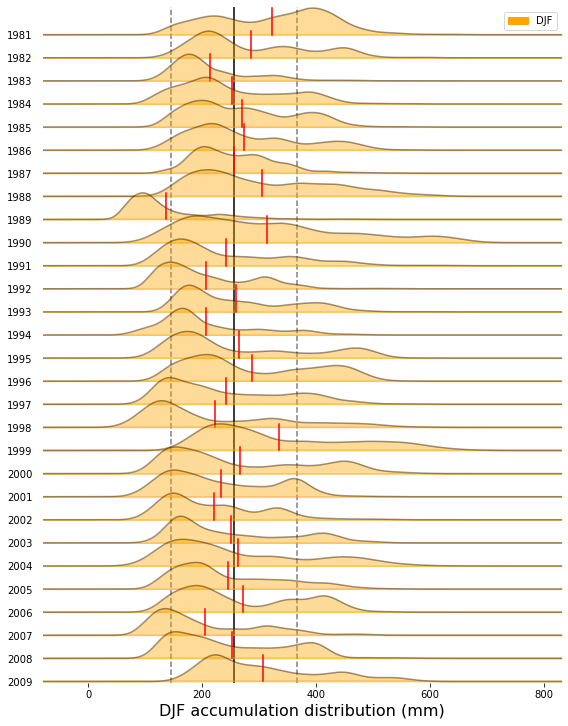

In [52]:
# over all basins
create_density_plots2('DJF',R_years_all,0.27, 'DJF accumulation distribution (mm)','orange')

<Figure size 2000x4000 with 0 Axes>

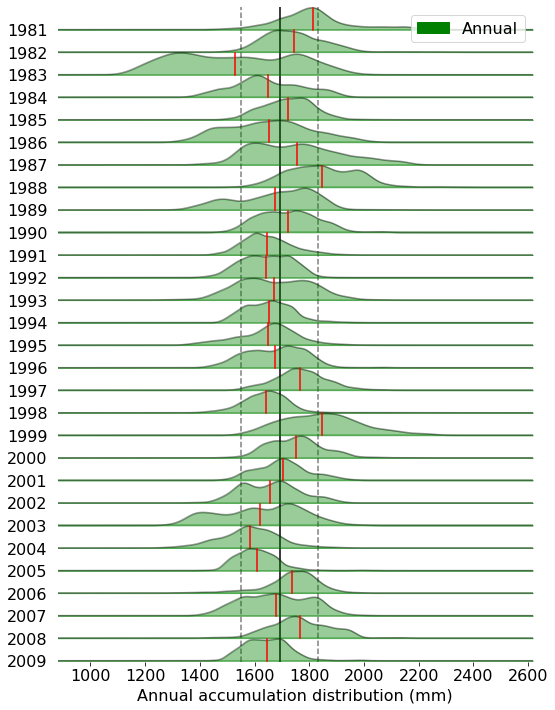

In [53]:
create_density_plots2('Annual',R_years_all,0.27, 'Annual accumulation distribution (mm)','green')

<Figure size 2000x4000 with 0 Axes>

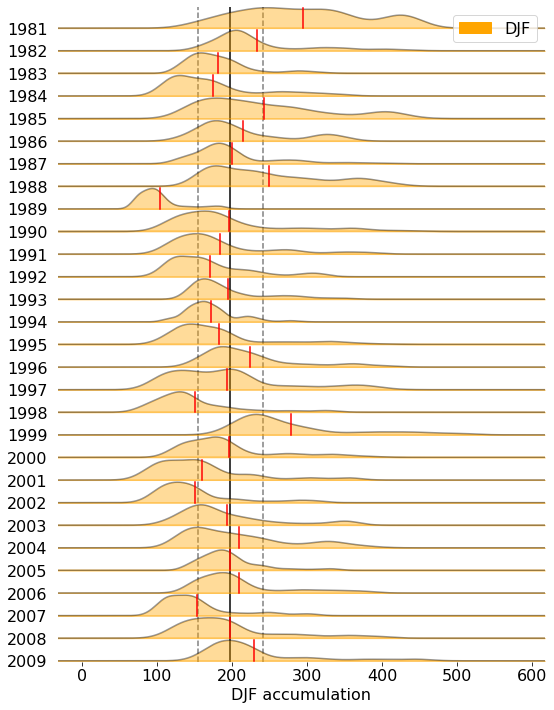

In [32]:
# single basin plots
create_density_plots('DJF',1,R_years,0.25,'DJF accumulation','orange')

<Figure size 2000x4000 with 0 Axes>

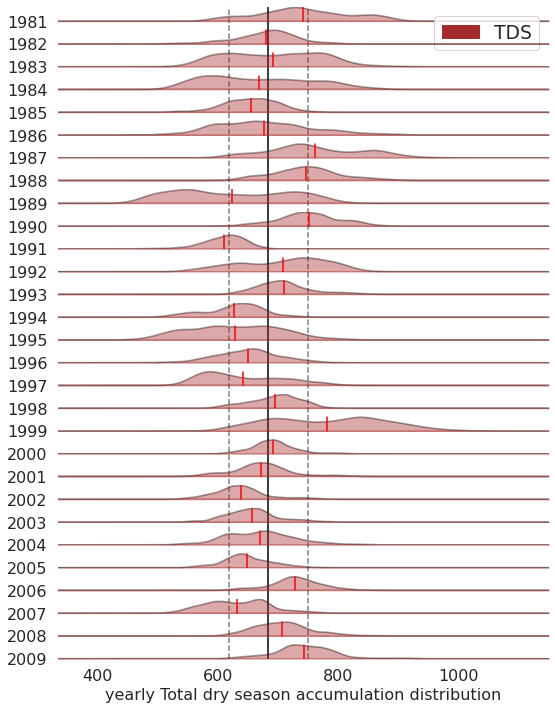

In [293]:
create_density_plots('TDS',2,R_years,0.25, 'Total dry season accumulation','brown')

<Figure size 2000x4000 with 0 Axes>

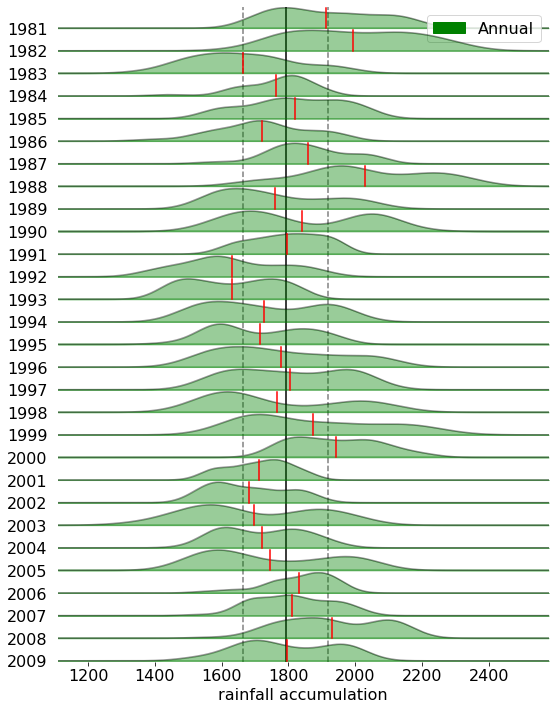

In [54]:
create_density_plots('Annual',5,R_years,0.25, 'rainfall accumulation','green')

<Figure size 2000x4000 with 0 Axes>

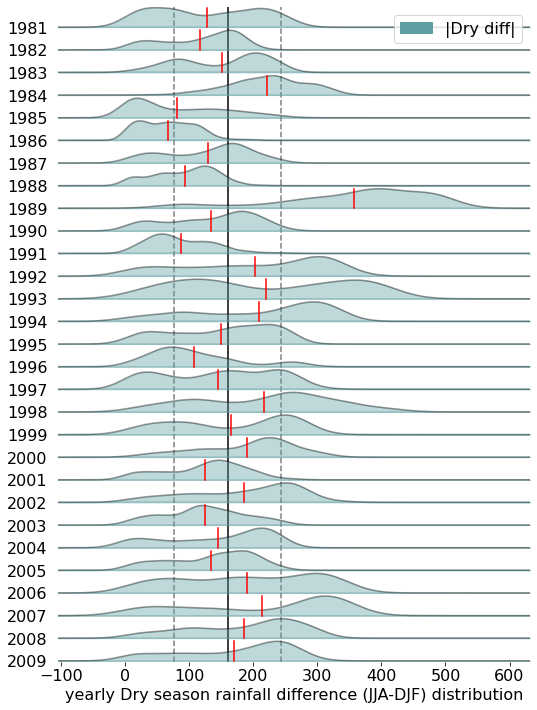

In [206]:
create_density_plots('JJA',13.0,R_years,0.25,'Dry season rainfall difference (JJA-DJF)', 'cadetblue')

In [319]:
# saving T_years and R_years
with open(PKL + 'R_years.pkl', 'wb') as f:
    pkl.dump(R_years, f)
    
with open(PKL + 'T_years.pkl', 'wb') as f:
    pkl.dump(T_years, f)